<a href="https://colab.research.google.com/github/HanifRafiq372/Stock-Forecasting/blob/main/stockforecasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# STOCK FORECASTING - FINAL VERSION
# Mandiri Sekuritas Technical Test

# Install dependencies (untuk Google Colab)
!pip -q install yfinance ta statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import ta
import warnings
warnings.filterwarnings("ignore")

# Library Machine Learning & Time Series
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Set seed biar hasil reprodusibel
np.random.seed(42)
tf.random.set_seed(42)

[*********************100%***********************]  1 of 1 completed


Dataset Shape: (1084, 2)
Price             Close     Volume
Ticker          BBRI.JK    BBRI.JK
Date                              
2020-01-02  2960.843262   45886302
2020-01-03  2967.557129   91189705
2020-01-06  2933.987549   48648450
2020-01-07  2954.129150  114344885
2020-01-08  2940.701904  188929583

[INFO] Ringkasan Statistik:
Price     Close        Volume
Ticker  BBRI.JK       BBRI.JK
count   1084.00  1.084000e+03
mean    3543.86  1.773971e+08
std      901.62  1.143285e+08
min     1513.76  2.767650e+07
25%     2935.66  1.046392e+08
50%     3488.65  1.457409e+08
75%     4128.57  2.081199e+08
max     5763.10  9.598846e+08

[INFO] Missing Values:
Price   Ticker 
Close   BBRI.JK    0
Volume  BBRI.JK    0
dtype: int64


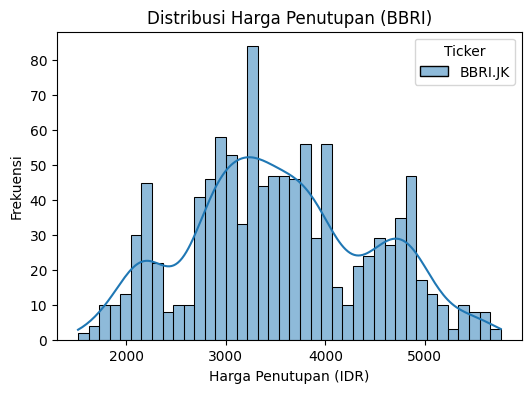

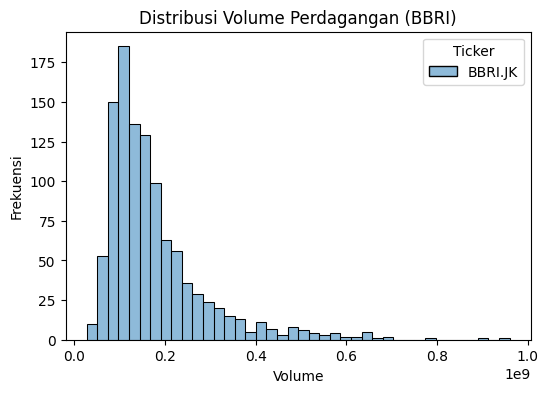

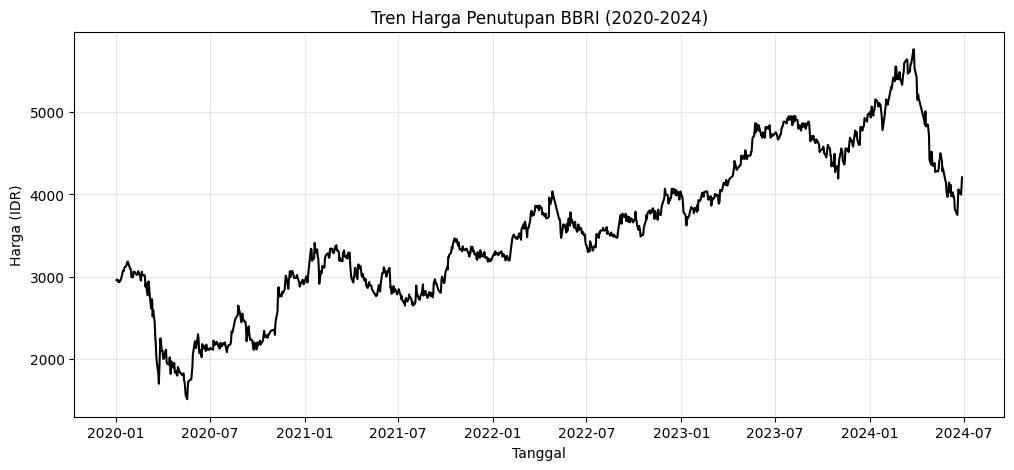

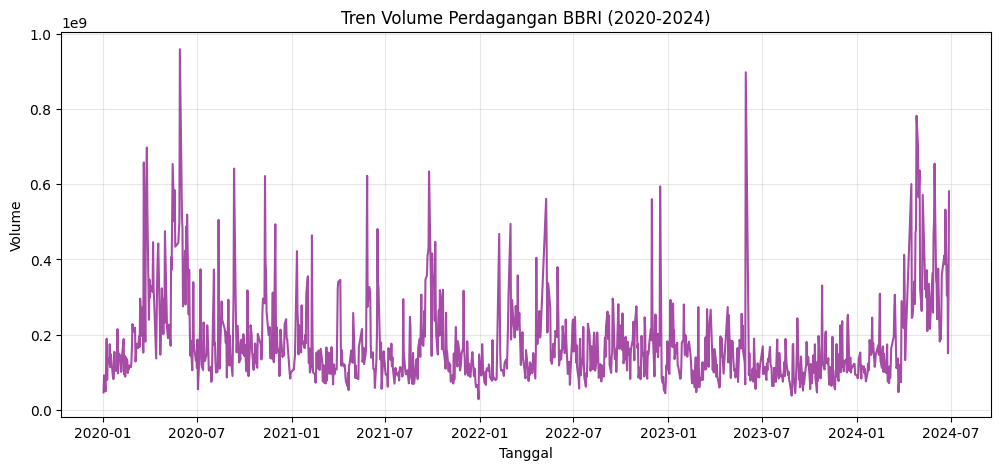

In [6]:
# 1. Data Loading
ticker = "BBRI.JK"   # Bank BRI (contoh saham IDX)
df = yf.download(ticker, start="2020-01-01", end="2024-07-01")

# Ambil kolom yang relevan
df = df[['Close', 'Volume']].dropna()

print(f"Dataset Shape: {df.shape}")
print(df.head())

# 1A. Dataset Overview / EDA Singkat
print("\n[INFO] Ringkasan Statistik:")
print(df.describe().round(2))

print("\n[INFO] Missing Values:")
print(df.isnull().sum())

# Distribusi harga penutupan
plt.figure(figsize=(6,4))
sns.histplot(df['Close'], bins=40, kde=True, color="blue")
plt.title("Distribusi Harga Penutupan (BBRI)")
plt.xlabel("Harga Penutupan (IDR)")
plt.ylabel("Frekuensi")
plt.show()

# Distribusi volume perdagangan
plt.figure(figsize=(6,4))
sns.histplot(df['Volume'], bins=40, color="orange")
plt.title("Distribusi Volume Perdagangan (BBRI)")
plt.xlabel("Volume")
plt.ylabel("Frekuensi")
plt.show()

# Tren harga penutupan
plt.figure(figsize=(12,5))
plt.plot(df['Close'], color="black")
plt.title("Tren Harga Penutupan BBRI (2020-2024)")
plt.xlabel("Tanggal")
plt.ylabel("Harga (IDR)")
plt.grid(alpha=0.3)
plt.show()

# Tren volume perdagangan
plt.figure(figsize=(12,5))
plt.plot(df['Volume'], color="purple", alpha=0.7)
plt.title("Tren Volume Perdagangan BBRI (2020-2024)")
plt.xlabel("Tanggal")
plt.ylabel("Volume")
plt.grid(alpha=0.3)
plt.show()

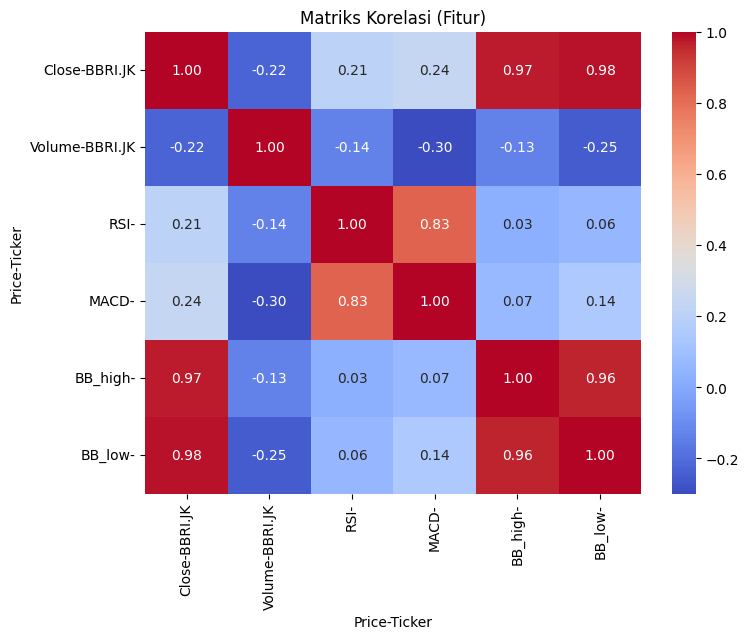

In [7]:
# 2. Feature Engineering
close_series = df['Close'].squeeze()

# Tambahkan indikator teknikal
df['RSI'] = ta.momentum.RSIIndicator(close_series).rsi()
macd = ta.trend.MACD(close_series)
df['MACD'] = macd.macd()
bb = ta.volatility.BollingerBands(close_series)
df['BB_high'] = bb.bollinger_hband()
df['BB_low']  = bb.bollinger_lband()

# Drop NA (indikator awal ada yang kosong)
df = df.dropna()

# Korelasi antar fitur
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriks Korelasi (Fitur)")
plt.show()

In [8]:
# 3. Train-Test Split
train_size = int(len(df)*0.8)
train = df.iloc[:train_size]
test  = df.iloc[train_size:]

train_close = train['Close']
test_close  = test['Close']

In [9]:
# 4. Baseline Models (Naive & ARIMA)
# --- Naive Forecast: harga hari ini = harga kemarin
df['Naive_Forecast'] = df['Close'].shift(1)

# --- ARIMA: pilih parameter terbaik via AIC
best_aic, best_order, best_model = np.inf, None, None
for p in range(0,6):
    for d in [0,1]:
        for q in range(0,4):
            try:
                m = ARIMA(train_close, order=(p,d,q)).fit()
                if m.aic < best_aic:
                    best_aic, best_order, best_model = m.aic, (p,d,q), m
            except:
                continue

print(f"[ARIMA] Best order: {best_order}, AIC={best_aic:.2f}")

# Forecast ARIMA
arima_pred = best_model.forecast(steps=len(test_close))
df['ARIMA'] = np.nan
df.loc[test_close.index, 'ARIMA'] = arima_pred.values

[ARIMA] Best order: (2, 1, 2), AIC=9386.85


In [10]:
# 5. LSTM Model
# Scaling data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(df[['Close']].values)

# Fungsi untuk buat sequence data
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)
lookback = 60
X_all, y_all = create_sequences(scaled_close, lookback)
aligned_index = df.index[lookback:]

# Split train-test
split_idx = int(len(X_all)*0.8)
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]
idx_test = aligned_index[split_idx:]

# Bentuk ulang untuk input LSTM
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# --- Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback,1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

# Early stopping untuk hindari overfitting
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Training
hist = model.fit(
    X_train, y_train,
    epochs=25, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[es], verbose=1
)

# Prediksi
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

df['LSTM'] = np.nan
df.loc[idx_test, 'LSTM'] = y_pred.flatten()

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0626 - val_loss: 0.0068
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0011 - val_loss: 0.0025
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


In [11]:
# 6. Evaluation
def directional_accuracy(y_true, y_pred):
    t = np.diff(y_true)
    p = np.diff(y_pred)
    return np.mean(np.sign(t) == np.sign(p))

# Naive
naive_true = test_close.values
naive_pred = df.loc[test_close.index, 'Naive_Forecast'].dropna().values
naive_true = naive_true[-len(naive_pred):]
naive_rmse = sqrt(mean_squared_error(naive_true, naive_pred))
naive_mape = mean_absolute_percentage_error(naive_true, naive_pred)

# ARIMA
arima_pred_aligned = df.loc[test_close.index, 'ARIMA'].values
arima_rmse = sqrt(mean_squared_error(test_close.values, arima_pred_aligned))
arima_mape = mean_absolute_percentage_error(test_close.values, arima_pred_aligned)

# LSTM
lstm_rmse = sqrt(mean_squared_error(y_test_actual, y_pred))
lstm_mape = mean_absolute_percentage_error(y_test_actual, y_pred)
lstm_da   = directional_accuracy(y_test_actual.flatten(), y_pred.flatten())

# Ringkasan
summary = pd.DataFrame({
    "Model": ["Naive","ARIMA","LSTM"],
    "RMSE":  [naive_rmse, arima_rmse, lstm_rmse],
    "MAPE":  [naive_mape, arima_mape, lstm_mape],
    "DA(%)": [np.nan, np.nan, lstm_da*100]
})
print("\n=== Model Performance Summary ===")
print(summary.round(4))


=== Model Performance Summary ===
   Model      RMSE    MAPE    DA(%)
0  Naive   80.8020  0.0132      NaN
1  ARIMA  481.3355  0.0869      NaN
2   LSTM  212.4340  0.0360  46.2312


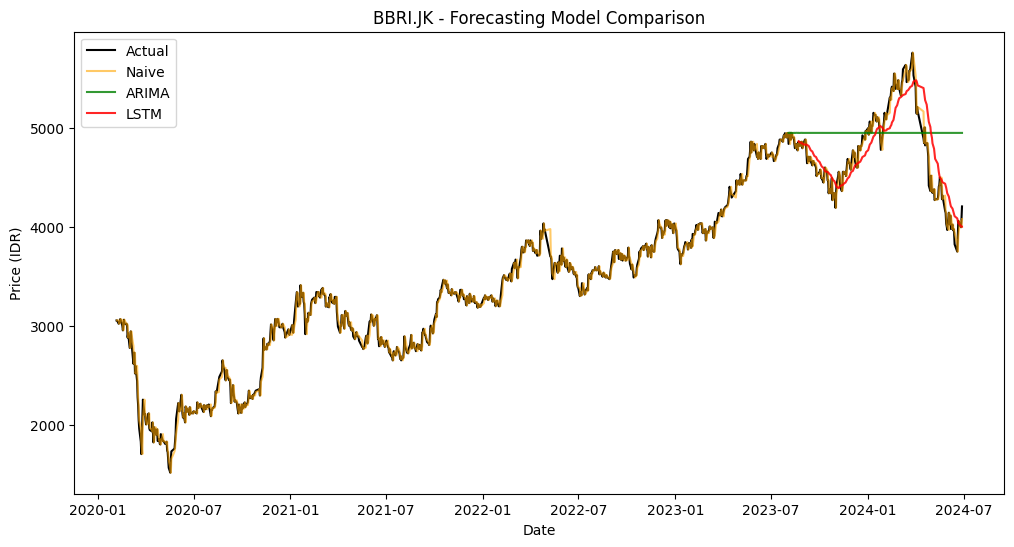

In [12]:
# 7. Visualization - Forecast Comparison
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Actual', color="black")
plt.plot(df['Naive_Forecast'], label='Naive', color="orange", alpha=0.6)
plt.plot(df['ARIMA'], label='ARIMA', color="green", alpha=0.8)
plt.plot(df['LSTM'], label='LSTM', color="red", alpha=0.85)
plt.title(f"{ticker} - Forecasting Model Comparison")
plt.xlabel("Date"); plt.ylabel("Price (IDR)")
plt.legend()
plt.show()

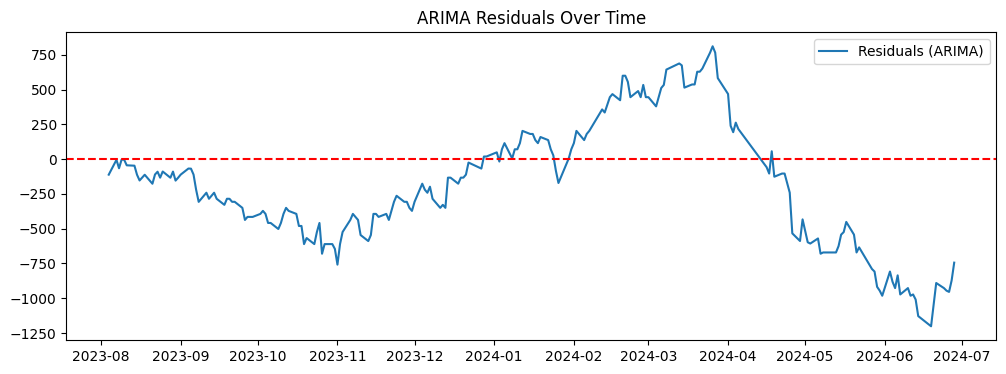

<Figure size 1000x300 with 0 Axes>

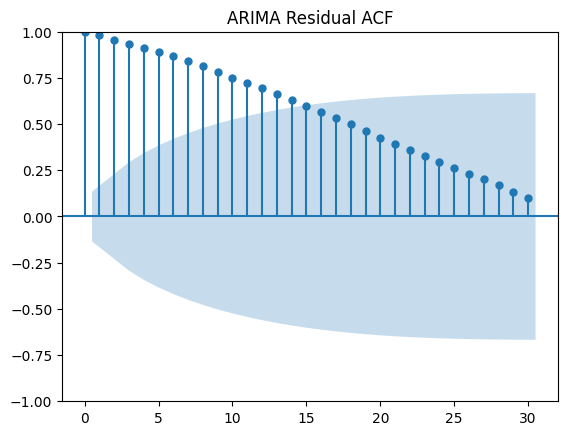

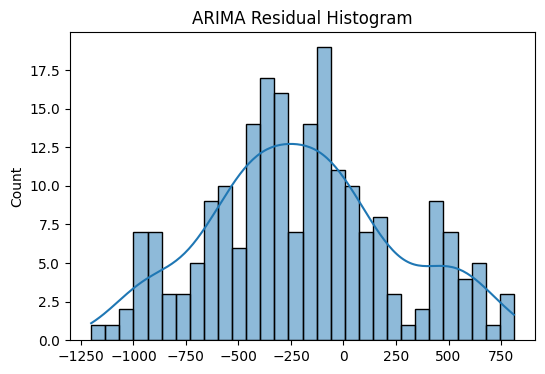

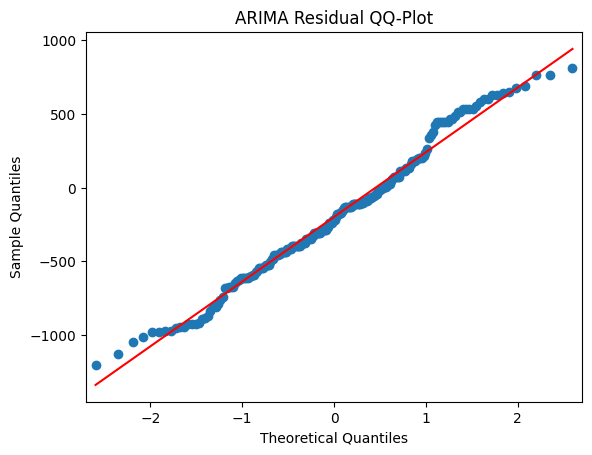

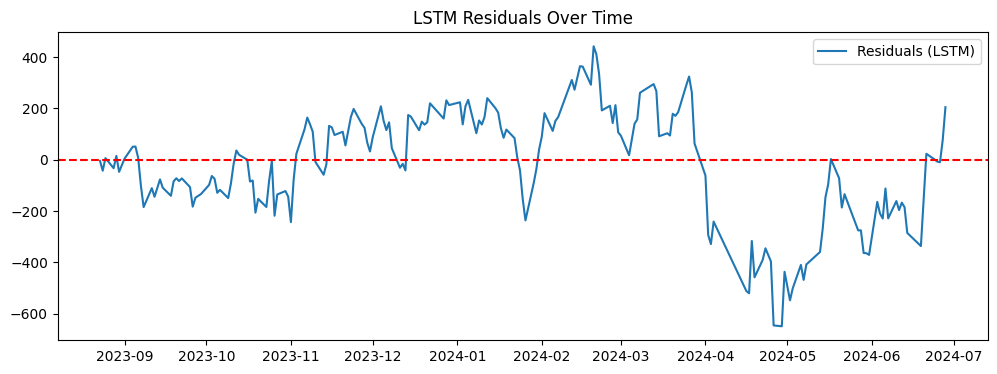

<Figure size 1000x300 with 0 Axes>

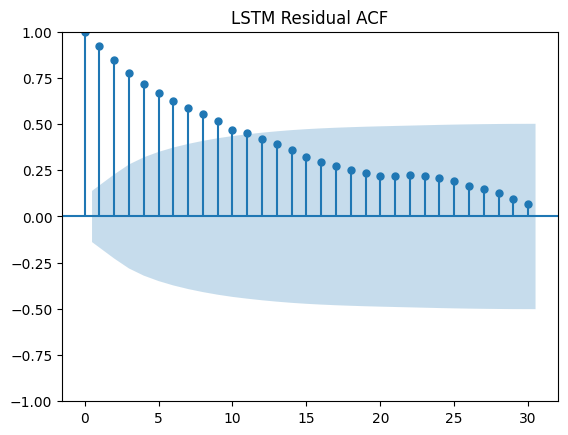

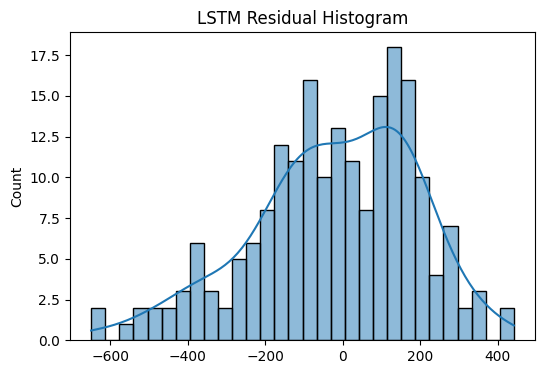

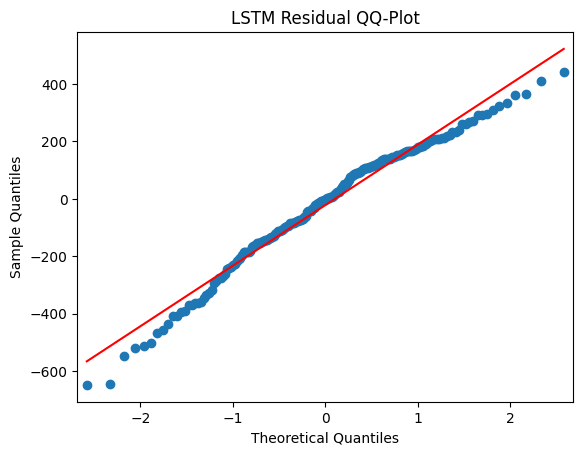

In [13]:
# 8. Residual Diagnostics
# Residuals ARIMA
res_arima = (test_close.values.flatten() - arima_pred_aligned.flatten())

plt.figure(figsize=(12,4))
plt.plot(test_close.index, res_arima, label="Residuals (ARIMA)")
plt.axhline(0, color="red", linestyle="--")
plt.title("ARIMA Residuals Over Time")
plt.legend(); plt.show()

plt.figure(figsize=(10,3))
plot_acf(res_arima, lags=30)
plt.title("ARIMA Residual ACF")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(res_arima, bins=30, kde=True)
plt.title("ARIMA Residual Histogram")
plt.show()

qqplot(res_arima, line='s')
plt.title("ARIMA Residual QQ-Plot")
plt.show()

# Residuals LSTM
res_lstm = (y_test_actual.flatten() - y_pred.flatten())

plt.figure(figsize=(12,4))
plt.plot(idx_test, res_lstm, label="Residuals (LSTM)")
plt.axhline(0, color="red", linestyle="--")
plt.title("LSTM Residuals Over Time")
plt.legend(); plt.show()

plt.figure(figsize=(10,3))
plot_acf(res_lstm, lags=30)
plt.title("LSTM Residual ACF")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(res_lstm, bins=30, kde=True)
plt.title("LSTM Residual Histogram")
plt.show()

qqplot(res_lstm, line='s')
plt.title("LSTM Residual QQ-Plot")
plt.show()

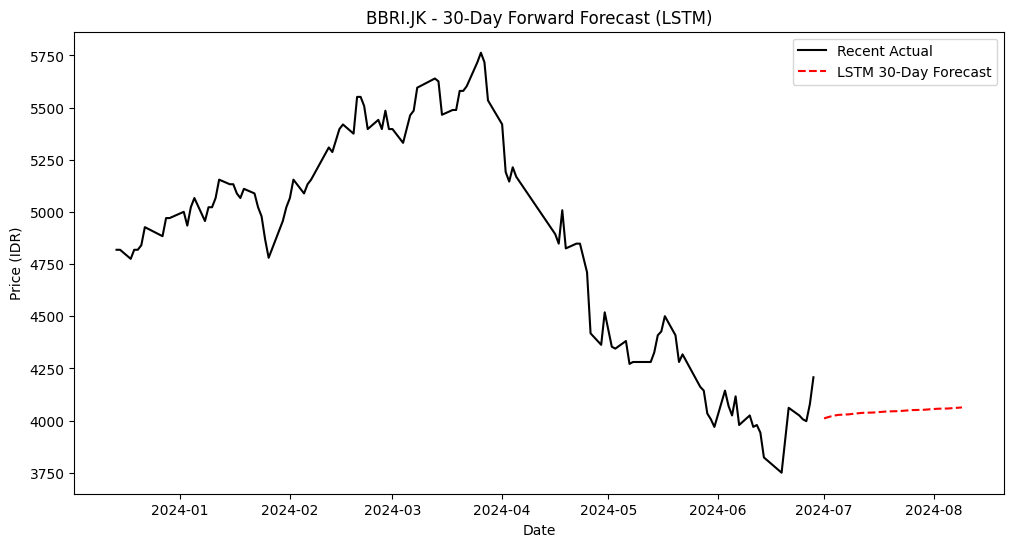

In [14]:
# 9. Scenario: 30-Day Forward Forecast (LSTM)
last_seq = scaled_close[-lookback:].reshape(1, lookback, 1)
future_scaled = []

for _ in range(30):
    nxt = model.predict(last_seq, verbose=0)
    future_scaled.append(nxt[0,0])
    last_seq = np.concatenate([last_seq[:,1:,:], nxt.reshape(1,1,1)], axis=1)

future = scaler.inverse_transform(np.array(future_scaled).reshape(-1,1)).flatten()
future_dates = pd.bdate_range(start=df.index[-1]+pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(12,6))
plt.plot(df.index[-120:], df['Close'].iloc[-120:], label='Recent Actual', color="black")
plt.plot(future_dates, future, '--', label='LSTM 30-Day Forecast', color="red")
plt.title(f"{ticker} - 30-Day Forward Forecast (LSTM)")
plt.xlabel("Date"); plt.ylabel("Price (IDR)")
plt.legend()
plt.show()